<a href="https://colab.research.google.com/github/PashaIanko/RestrictedBolzmannMachine/blob/EMNIST/Omniglot_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Helper links:
- https://github.com/pytorch/vision/blob/main/torchvision/datasets/omniglot.py

## **Packages, Constants & Functions**

In [1]:
# Preprocessing
CROP_SIZE_ = 28
MEAN_ = 0.1307
STD_ = 0.3081
IMG_SIZE_ = CROP_SIZE_

# Train
EPOCHS_ = 50
BATCH_SIZE_ = 100
TRAIN_SIZE_ = 10000 # 50000
TEST_SIZE_ = 10000

# Receprive fields visualization
VISUALIZATION_THRESH_ = 0.1

# Alphabets
# key - alphabet, value - start and finish labels

# Model
VISIBLE_UNITS_ = IMG_SIZE_ * IMG_SIZE_
HIDDEN_UNITS_ = [500]  # [500, 500]
N_HIDDEN_LAYERS_ = len(HIDDEN_UNITS_)
K_ = 1
LEARNING_RATE_ = 0.1
LR_DECAY_ = False
INIT_MOMENTUM_ = 0.5
FIN_MOMENTUM_ = 0.9
W_DECAY_ = 0.00002
XAVIER_INIT_ = False
INCREASE_TO_CD_K_ = False
USE_GPU_ = True

In [2]:
%%capture

url_dbn = 'https://raw.githubusercontent.com/PashaIanko/RestrictedBolzmannMachine/main/DBN.py'
url_rbm = 'https://raw.githubusercontent.com/PashaIanko/RestrictedBolzmannMachine/main/RBM.py'
#ffnn = 'https://github.com/PashaIanko/RestrictedBolzmannMachine/blob/EMNIST/FFNN.pkl'
#dbn = 'https://github.com/PashaIanko/RestrictedBolzmannMachine/blob/EMNIST/DBN.pkl'

utils = {
    'DBN.py': url_dbn,
    'RBM.py': url_rbm,
    #'FFNN.pkl': ffnn,
    #'DBN.pkl': dbn
}

for file, url in utils.items():
    !wget -O {file} {url} {file}

In [3]:
import torch
import torchvision as tv
from torchvision import datasets

# Models
from DBN import DBN

# Plotting
import matplotlib.pyplot as plt

# Download
from os import path

# Utils
from scipy import cluster
import numpy as np
import random
import math
import tqdm

# Plotting
import seaborn as sns

In [4]:
def fix_seeds():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

In [5]:
def visualize_symbols(dataset, n_subplots, image_shape):
    n_rows_cols = int(math.sqrt(n_subplots))
    fig, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = (10, 10)
    )
    for i in range(n_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        img = dataset[i] 
        axes[row, col].imshow(torch.flatten(img).reshape(image_shape), cmap='binary')

In [6]:
def find_image(ds, label):
    for item in ds:
        if item[1] == label:
            return item[0]

def visualize_labels(labels, data, targets):
    n_subplots = len(labels)
    
    n_rows_cols = int(math.sqrt(n_subplots))
    fig, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = (10, 10)
    )

    for i in range(n_subplots):
        col = i % n_rows_cols
        row = i // n_rows_cols
        label = labels[i]
        
        img_index = np.where(targets == label)[0][0]
        image = data[img_index]
        axes[row, col].imshow(image, cmap = 'binary')

def prepare_data(ds, label_from, label_to):
    labels = []
    images = []
    for item in ds:
        if label_from <= item[1] <= label_to:
            labels.append(item[1])
            images.append(item[0])
    return images, labels

In [7]:
def move_parameters_to_cpu(dbn_mnist):
    for layer in dbn_mnist.rbm_layers:
        layer.W = layer.W.cpu()
        layer.h_bias = layer.h_bias.cpu()
        layer.v_bias = layer.v_bias.cpu()

def apply_threshold(weights, threshold=0):
    return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights_matrices, num_subplots = 64, 
                                img_width=IMG_SIZE_, img_height=IMG_SIZE_, 
                                fig_size = (20, 20)):
    n_rows_cols = int(math.sqrt(num_subplots))
    fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=fig_size)
    for i in range(num_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        
        # Matrix of connection strength (W) of i-th unit of the layer.
        # Reshape from 'linear' to 'image' representation
        W_matrix = weights_matrices[i, :].reshape((img_height, img_width))
        axes[row, col].imshow(W_matrix, cmap = plt.cm.gray)

In [8]:
def project_hidden_layer(weights_matrices, layer_numb):
    
    # layer_numb starts from 2 (number of hidden layer)
    if layer_numb > len(weights_matrices):
        print(f'Mistake in project_hidden_layer, accessing wrong layer')
        return 
    layers = weights_matrices[:layer_numb]
    cur_layer = layers[0]
    for i in range(1, len(layers)):
        cur_layer = layers[i] @ cur_layer
    return cur_layer

## **Data Download**

- For neural networks, we need to scale data before learning
- Need to obtain tensor shape
- Fix seeds for reproducibility

In [9]:
%%capture 

transformer = tv.transforms.Compose(
    [
        #tv.transforms.CenterCrop(CROP_SIZE_),
        tv.transforms.ToTensor(),
        
        # Transform to {-1, 1} binary image
        tv.transforms.Normalize(mean=(MEAN_,), std=(STD_)),

        # Rotate
        # tv.transforms.RandomRotation(degrees = 90) 
    ]
)

data = tv.datasets.EMNIST(
    root = 'data/',
    train = True,
    download = True,
    transform = transformer,
    split = 'digits',
    # shuffle = False
)
# test = tv.datasets.EMNIST(
#     root = 'data/',
#     train = False,
#     download = True,
#     transform = transformer,
#     split = 'digits',
#     # shuffle_files = False
# )

In [10]:
data.data = (data.data.type(torch.FloatTensor) / 255)
print(f'Data size: {data.data.shape}')

Data size: torch.Size([240000, 28, 28])


The number shown is the number: 1
torch.Size([28, 28])


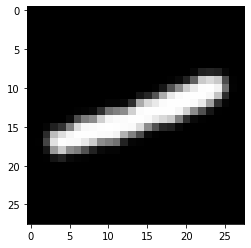

In [11]:
idx = 105
img = data.data[idx]
print("The number shown is the number: {}".format(data.targets[idx]) )
print(data.data[idx].shape)
plt.imshow(img , cmap = 'gray')
plt.show()

In [12]:
data_train = data.data[: TRAIN_SIZE_, :]
targets_train = data.targets[: TRAIN_SIZE_]

data_test = data.data[TRAIN_SIZE_ : TRAIN_SIZE_ + TEST_SIZE_, :]
targets_test = data.targets[TRAIN_SIZE_ : TRAIN_SIZE_ + TEST_SIZE_]

print(f"""
        Train size: {data_train.shape, targets_train.shape}
        Test size: {data_test.shape, targets_test.shape}
      """)


        Train size: (torch.Size([10000, 28, 28]), torch.Size([10000]))
        Test size: (torch.Size([10000, 28, 28]), torch.Size([10000]))
      


In [13]:
image, label = data_train[0], targets_train[0]
print(f"""
    Class presence in train: {np.unique(targets_train)}
    Class presence in test: {np.unique(targets_test)}
    Image shape: {image.shape}
    Label: {label}
""")


    Class presence in train: [0 1 2 3 4 5 6 7 8 9]
    Class presence in test: [0 1 2 3 4 5 6 7 8 9]
    Image shape: torch.Size([28, 28])
    Label: 8



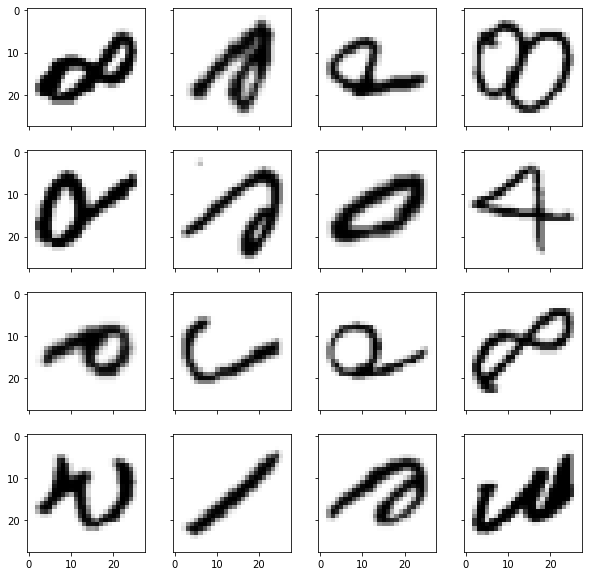

In [14]:
visualize_symbols(data_train, 16, image_shape = (CROP_SIZE_, CROP_SIZE_))

## **Data properties & visualization**

C:\Users\79137\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\79137\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Test class distribution')

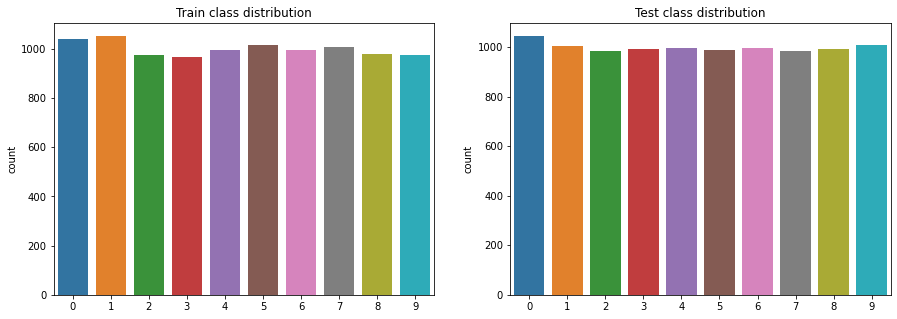

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
sns.countplot(
    targets_train.numpy(), ax = axes[0]
)
axes[0].set_title('Train class distribution')

sns.countplot(
    targets_test.numpy(), 
    ax = axes[1]
)
axes[1].set_title('Test class distribution')

- 1st conclusion:  
    - 1 Dataset
    - 10 distinct symbols (for 'digits' split)
    - Approximately uniform class distribution
    - ~ 10% images per class
    - Digits are centered in the image and do not occupy the whole square (-> apply center crop)

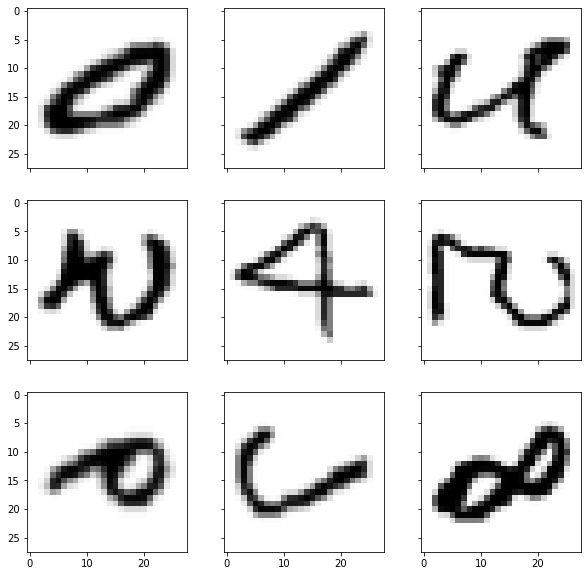

In [16]:
# Visualize first few symbols
visualize_labels(
    labels = [0, 1, 2,
              3, 4, 5,
              6, 7, 8
              ],
    data = data_train,
    targets = targets_train
)

## **Deep Belief Network model & fit**

- Deep Belief Network - a stack of Restricted Bolzmann Machines
    - RBM is a bipartite graph with input and hidden layer
    - Hidden layer captures dependencies and features
- Each layer learns more complex and abstract features
- Used as feature extraction method (generative model)
- No output neurons
- Two phases (negative & positive) during learning (reconstruction)




In [17]:
fix_seeds()

model = DBN(
    visible_units = VISIBLE_UNITS_,
    hidden_units = HIDDEN_UNITS_,
    k = K_,
    learning_rate = LEARNING_RATE_,
    learning_rate_decay = LR_DECAY_,
    initial_momentum = INIT_MOMENTUM_,
    final_momentum = FIN_MOMENTUM_,
    weight_decay = W_DECAY_,
    xavier_init = XAVIER_INIT_,
    increase_to_cd_k = INCREASE_TO_CD_K_,
    use_gpu = USE_GPU_
)

In [18]:
%%capture

fix_seeds()

model.train_static(
    data_train,
    targets_train,
    EPOCHS_,
    BATCH_SIZE_
)

move_parameters_to_cpu(model)

## Linear read-outs. Receptive fields visualization

Lets understand the structure of network & layers
- Input layer size - (IMG_SIZE_ * IMG_SIZE_)
- 0-level of RBM network with N units -> has connection matrix W. 
Size of W = N_units * (IMG_SIZE_ * IMG_SIZE_)
- We can consider W matrix of 0-level as N "images" of size (IMG_SIZE_ * IMG_SIZE_)
- Hence, we can visualize connection strengths, starting from 0 hidden level

In [19]:
print(type(model.rbm_layers[0].W))
print(type(model.rbm_layers[0].W.numpy()))
print(model.rbm_layers[0].W.size())
print(model.rbm_layers[1].W.size())

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
torch.Size([784, 500])


IndexError: list index out of range

### Preprocessing (filtering) learned weights matrices

In [20]:
# Converting and processing W matrices of hidden layers

learned_weights = [
    # We transpose for convenience (matrices[i, :] is more intuitive than matrices[:, i])
    model.rbm_layers[i].W.transpose(0, 1).numpy() for i in range(N_HIDDEN_LAYERS_)  
]

learned_weights_thresh = [
                          apply_threshold(weights_matrix, VISUALIZATION_THRESH_) 
                            for weights_matrix in learned_weights
]

### First hidden layer receptive fields

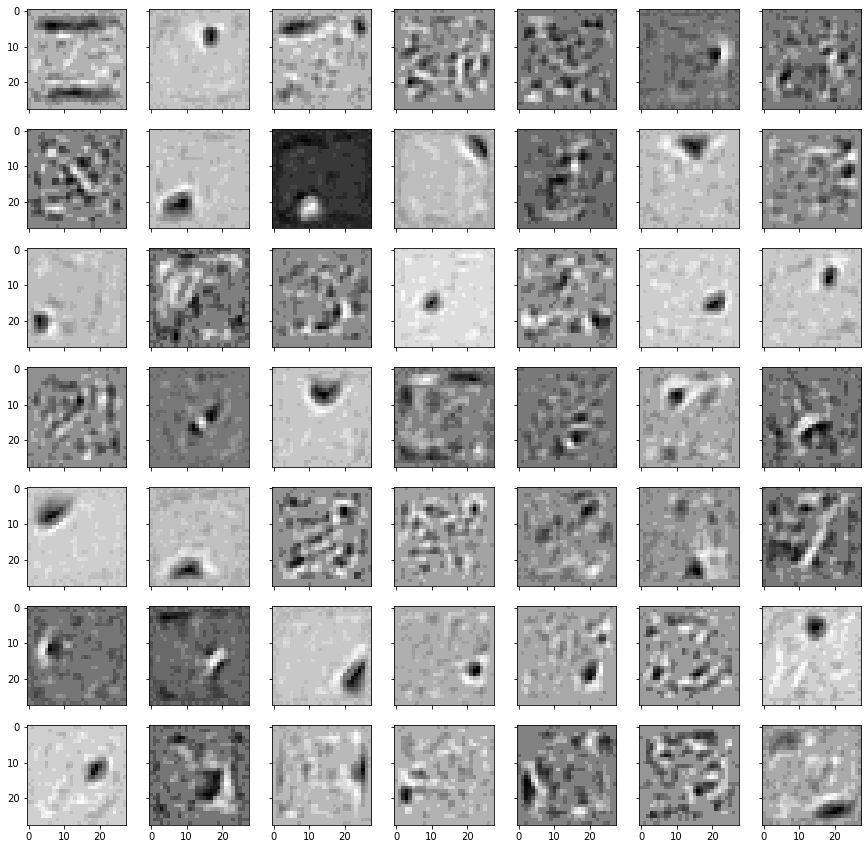

In [21]:
plot_layer_receptive_fields(
    # N_units * (img_size * img_size) - dimension of 1st hidden layer
    learned_weights_thresh[0],  
    num_subplots=49,
    img_height = IMG_SIZE_,
    img_width = IMG_SIZE_, 
    fig_size = (15, 15)
)

### Second hidden layer receptive field

- For example, in the architecture with units = [500, 500, 2000], the second hidden layer consists of 500 units, each associated with 500 units of the 1st hidden layer (500 x 500 matrix)
- We need to visualize (IMG_SIZE_ * IMG_SIZE_) images of 2nd hidden layer receptive fields
- The dimension of 1st hidden layer is n_units * (IMG_SIZE * IMG_SIZE).
- **Therefore**, we need to perform matrix multiplication, to turn (500 x 500) layer to (500 x (IMG_SIZE x IMG_SIZE)) layer

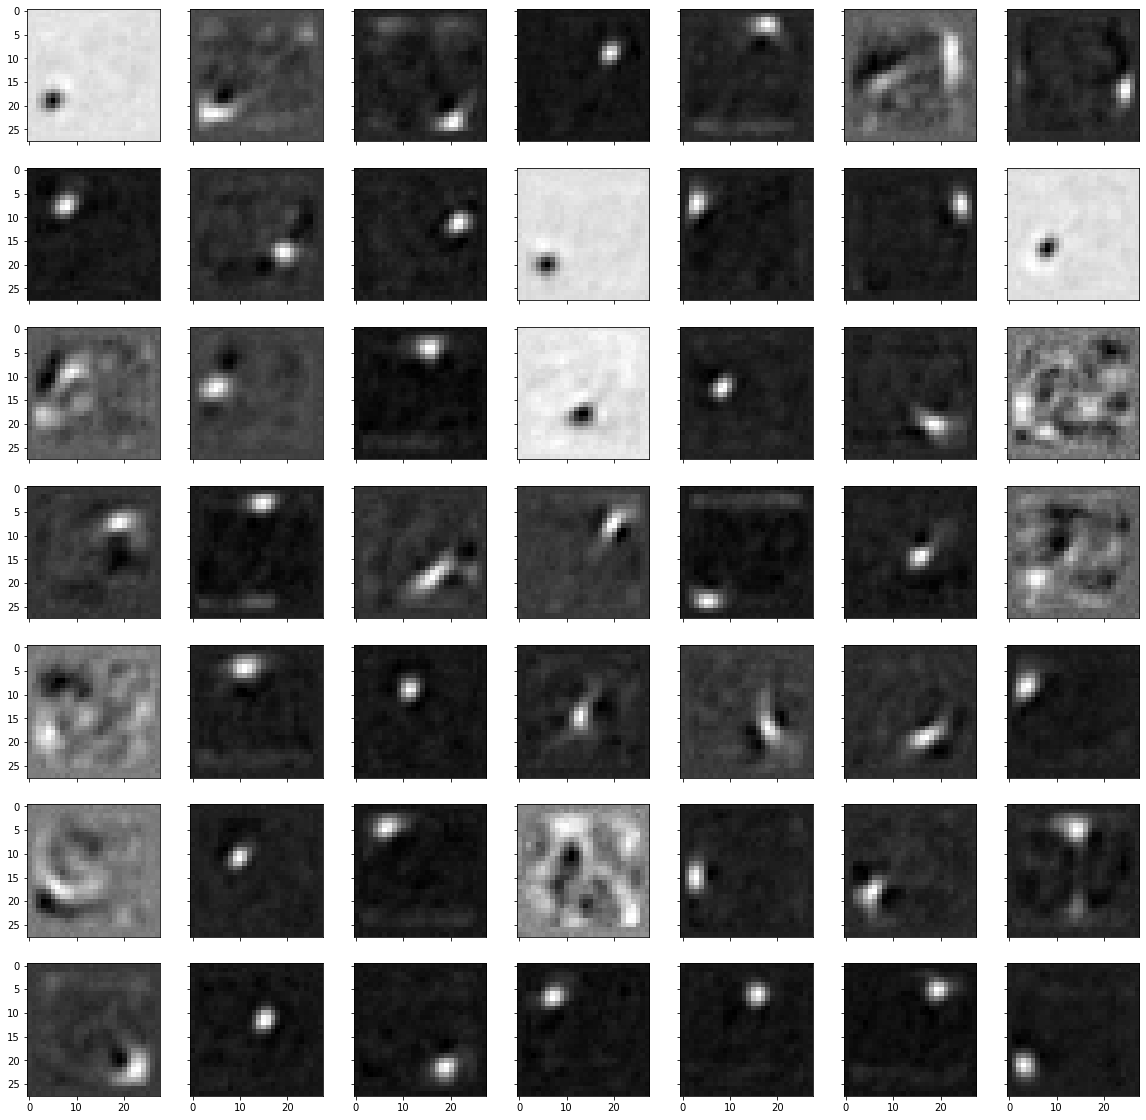

In [ ]:
plot_layer_receptive_fields(
    project_hidden_layer(
        learned_weights_thresh,
        layer_numb = 2
    ), 
    num_subplots = 49
)

### Third hidden layer receptive fields

In [ ]:
# plot_layer_receptive_fields(
#     project_hidden_layer(
#         learned_weights_thresh,
#         layer_numb = 3
#     ),
#     num_subplots = 49
# )

## Clustering internal representations

In [22]:
def get_layer_representation(input, model, layer_number):
    flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
    hidden_repr, _ = model.rbm_layers[layer_number].to_hidden(flattened_input)
    return hidden_repr

In [23]:
hidden0 = get_layer_representation(
    input = data_train,
    model = model,
    layer_number = 0
)

In [ ]:
hidden1 = get_layer_representation(
    input = hidden0,
    model = model,
    layer_number = 1
)

In [24]:
def get_mask(labels, label):
    return labels.numpy() == label

def label_to_mean_hidden_repr(hidden_representation, images, labels):
    hidden_representation_np = hidden_representation.numpy()
    return {
        label: hidden_representation_np[get_mask(labels, label)].mean(axis=0)
        for label in np.unique(labels.numpy())
    }

def get_hidden_representation_matrix(label_to_mean_hidden_repr, labels):
    return np.concatenate(
        [np.expand_dims(
            label_to_mean_hidden_repr[label], axis = 0
        )
        for label in np.unique(labels.numpy())]
    )

In [25]:
label_to_mean0 = label_to_mean_hidden_repr(
    hidden0,
    data_train,
    targets_train
)

In [ ]:

label_to_mean1 = label_to_mean_hidden_repr(
    hidden1,
    data_train,
    targets_train
)

In [26]:
mean_hidd_repr_mat0 = get_hidden_representation_matrix(
    label_to_mean0,
    targets_train
)

In [ ]:
mean_hidd_repr_mat1 = get_hidden_representation_matrix(
    label_to_mean1,
    targets_train
)

In [27]:
def plot_dendrogram(mean_repr_matrix, title = ''):
    fig, ax = plt.subplots()
    linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
    dendrogram = cluster.hierarchy.dendrogram(linkage)
    ax.set_title(title)
    return dendrogram

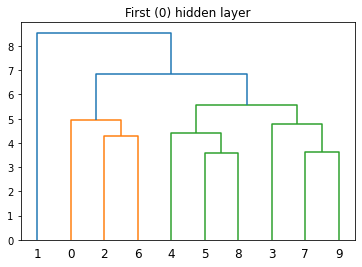

In [28]:
dendrogram0 = plot_dendrogram(mean_hidd_repr_mat0, title = 'First (0) hidden layer')

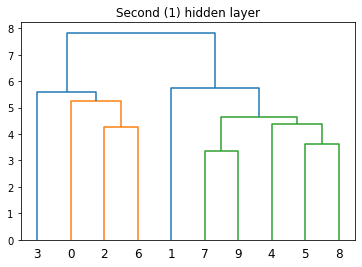

In [ ]:
dendrogram1 = plot_dendrogram(
    mean_hidd_repr_mat1,
    title = 'Second (1) hidden layer'
)

## Readout layer train

In [29]:
def _train(network, input, targets, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input)  # .squeeze()
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))
    
class Perceptron(torch.nn.Module):
  def __init__(self, rbm_layer_size, class_num):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, class_num)  # because 10 classes. You declare input and output

  def forward(self, x):  # called when applied on some data, basic method
    return self.linear(x)

In [30]:
rbm_layer_size = model.rbm_layers[0].W.shape[1]
perceptron_first_hidden = Perceptron(rbm_layer_size, class_num = 10)

# As input - hidden representation
_train(
    perceptron_first_hidden, 
    hidden0, 
    targets = targets_train, 
    epochs=1500
)

epoch 0/1500, loss = 2.324348
epoch 100/1500, loss = 0.649895
epoch 200/1500, loss = 0.468633
epoch 300/1500, loss = 0.395079
epoch 400/1500, loss = 0.352877
epoch 500/1500, loss = 0.324595
epoch 600/1500, loss = 0.303876
epoch 700/1500, loss = 0.287793
epoch 800/1500, loss = 0.274789
epoch 900/1500, loss = 0.263955
epoch 1000/1500, loss = 0.254717
epoch 1100/1500, loss = 0.246696
epoch 1200/1500, loss = 0.239627
epoch 1300/1500, loss = 0.233323
epoch 1400/1500, loss = 0.227643


In [31]:
# Now we calculate hidden representations on the test dataset
def compute_accuracy(predictions, targets):
  predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

hidden_test = get_layer_representation(
    input = data_test,
    model = model,
    layer_number = 0
)
predictions_test = perceptron_first_hidden(
    hidden_test
)

In [32]:
compute_accuracy(
    predictions_test,
    targets_test
)

0.9399999976158142

## FFNN comparison

In [33]:
class FeedForward(torch.nn.Module):
  def __init__(self,
               first_hidden_layer_size,
               class_num,
               input_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(input_size, first_hidden_layer_size)
    self.output = torch.nn.Linear(first_hidden_layer_size, class_num)

  def forward(self, input):
    input = input.view((input.shape[0], -1))
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    output = self.output(first_hidden_repr)
    return output

In [34]:
ffnn = FeedForward(
    first_hidden_layer_size = 500,
    class_num = 10,
    input_size = 784
)

In [35]:
data_train.shape

torch.Size([10000, 28, 28])

In [36]:
_train(
    ffnn,
    data_train,
    targets = targets_train,
    epochs = 120
)

epoch 0/120, loss = 2.311869
epoch 10/120, loss = 2.174327
epoch 20/120, loss = 2.024380
epoch 30/120, loss = 1.846321
epoch 40/120, loss = 1.647345
epoch 50/120, loss = 1.445746
epoch 60/120, loss = 1.259633
epoch 70/120, loss = 1.099959
epoch 80/120, loss = 0.969462
epoch 90/120, loss = 0.865432
epoch 100/120, loss = 0.783035
epoch 110/120, loss = 0.717455


In [37]:
preds_ffnn = ffnn(
    data_test.reshape(
        (data_test.shape[0], data_test.shape[1] * data_test.shape[2])
    )
)
compute_accuracy(
    preds_ffnn,
    targets_test
)

0.8611000180244446

## Robustness to noise

In [38]:
def inject_noise(mnist_data, noise_level):
  random_gaussian_tensor = torch.randn(mnist_data.shape)/6.6 + .6
  probability_tensor = torch.ones(mnist_data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return mnist_data - mask_tensor * mnist_data + mask_tensor * random_gaussian_tensor

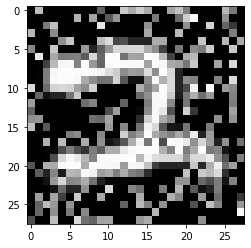

In [39]:
noise_level = 0.3
data_test_with_noise = inject_noise(data_test, noise_level)
_ = plt.imshow(data_test_with_noise[1000].reshape(28, 28), cmap="gray")

In [40]:
def accuracy_at_noise_level(
    noisy_input,
    targets,

    rbm_model,
    hidden_layer_number,

    perceptron_model,
    ffnn_model
):
  
  hidden_repr_noisy = get_layer_representation(noisy_input, rbm_model, hidden_layer_number)

  predictions_hidden = perceptron_model(hidden_repr_noisy)
  predictions_ffnn = ffnn_model(noisy_input.reshape(
      (noisy_input.shape[0], noisy_input.shape[1] * noisy_input.shape[2]))
  )
  
  acc_hidden = compute_accuracy(predictions_hidden, targets)
  acc_ffnn = compute_accuracy(predictions_ffnn, targets)
  return acc_hidden, acc_ffnn

In [41]:
acc_hidden, acc_ffnn = accuracy_at_noise_level(
    noisy_input = inject_noise(data_test, noise_level = 0.2),
    targets = targets_test,

    rbm_model = model,
    hidden_layer_number = 0,

    perceptron_model = perceptron_first_hidden,
    ffnn_model = ffnn
)

In [42]:
acc_hidden, acc_ffnn

(0.8396000266075134, 0.8409000039100647)

In [43]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    accuracy_first_hidden, accuracy_ffnn = accuracy_at_noise_level(
        noisy_input = inject_noise(data_test, noise_level),
        targets = targets_test,

        rbm_model = model,
        hidden_layer_number = 0,

        perceptron_model = perceptron_first_hidden,
        ffnn_model = ffnn
    )
    accuracy_values_first_hidden.append(accuracy_first_hidden)
    accuracy_values_ffnn.append(accuracy_ffnn)

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "FFNN"])

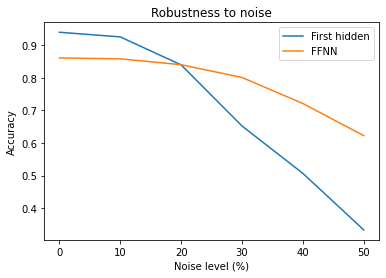

In [44]:
levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
plot_noise_robustness_curves(levels)

## Adversarial attacks

In [45]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_model, perceptron):
        super().__init__()
        self.readout = perceptron
        self.dbn_model = dbn_model

    def forward(self, image):
        x, _ = self.dbn_model.forward(image)
        x = self.readout.forward(x)
        return x

In [46]:
dbn_with_readout = DBNWithReadOut(
    dbn_model = model,
    perceptron = perceptron_first_hidden
)

## Example of adversarial attack

Prediction: 6, label = 6, model output = tensor([[-0.5614,  1.7487,  1.4212, -0.0306, -0.5571,  0.6309,  2.6549, -2.9577,
          1.3685, -2.0405]], grad_fn=<AddmmBackward0>)


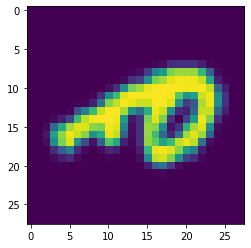

In [47]:
idx = 150
test_label = targets_test[idx]
test_image = data_test[idx].reshape(1, 28, 28)
_ = plt.imshow(test_image.reshape(28, 28))

test_image.requires_grad = True

attacked_model = ffnn
model_output = attacked_model(test_image)
pred = torch.argmax(model_output)
print(f'Prediction: {pred}, label = {test_label}, model output = {model_output}')

In [48]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [49]:
loss = torch.nn.functional.cross_entropy(
    target = torch.tensor([test_label]),
    input = model_output
)
print(loss)
attacked_model.zero_grad()
loss.backward()
image_grad = test_image.grad.data

tensor(0.8176, grad_fn=<NllLossBackward0>)


In [50]:
perturbed_image = fgsm_attack(test_image, 0.2, image_grad)

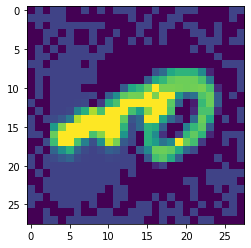

In [51]:
perturbed_image_np = perturbed_image.detach().numpy()
_ = plt.imshow(perturbed_image_np.reshape(28, 28))

In [53]:
model_outputs = attacked_model(perturbed_image)
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 1.


# Resisting to adversarial attacks

In [60]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm.tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(1, 28, 28)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data.detach().numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_model.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    if verbose:
      print("\nEpsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon,
            correct, len(test_loader), final_acc))

    return final_acc

In [55]:
test_loader = torch.utils.data.DataLoader(
    dataset = tv.datasets.EMNIST(
        root = 'data/',
        train = False,
        download = True,
        transform = transformer,
        split = 'digits',
        # shuffle = False
    ),
    batch_size = 1,
    shuffle = True
)

In [56]:
device = torch.device('cpu')

In [57]:
import torch.nn.functional as functional 

final_acc = test_robustness_to_attack(
    ffnn, 
    device,
    test_loader,
    epsilon = 0.1,
    num_steps = 0
)

100%|██████████| 40000/40000 [01:00<00:00, 666.08it/s]


Epsilon: 0.1	Test Accuracy = 32685 / 40000 = 0.817125



In [58]:
final_acc = test_robustness_to_attack(
    dbn_with_readout, 
    device,
    test_loader,
    epsilon=0.1, 
    num_steps=0
)

100%|██████████| 40000/40000 [00:40<00:00, 988.95it/s] 


Epsilon: 0.1	Test Accuracy = 30229 / 40000 = 0.755725



  0%|          | 0/40000 [00:00<?, ?it/s]


Here's the original sample:



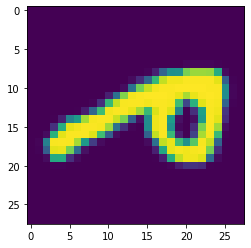


Here's a perturbed sample:



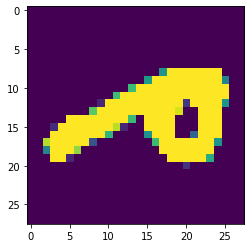


Here's what a 1-steps reconstructed sample looks like:



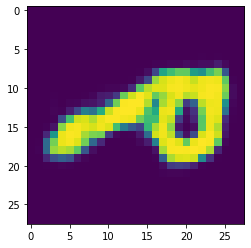

100%|██████████| 40000/40000 [00:57<00:00, 694.04it/s]


Epsilon: 0.1	Test Accuracy = 30097 / 40000 = 0.752425



In [61]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

  0%|          | 0/40000 [00:00<?, ?it/s]


Here's the original sample:



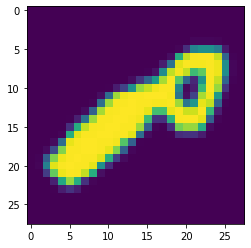


Here's a perturbed sample:



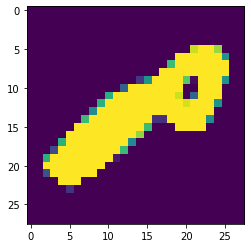


Here's what a 2-steps reconstructed sample looks like:



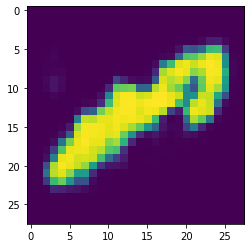

100%|██████████| 40000/40000 [01:07<00:00, 595.05it/s]


Epsilon: 0.1	Test Accuracy = 29900 / 40000 = 0.7475



In [62]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=2)

# Effect of $\epsilon$

In [65]:
epsilon_values = [0, 0.2]  # [0, .05, .1, .15, .2, .25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [66]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_rbm_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
# accuracies_rbm_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)
accuracies_rbm_2 = test_epsilon_values_effect(dbn_with_readout, n_steps=2)

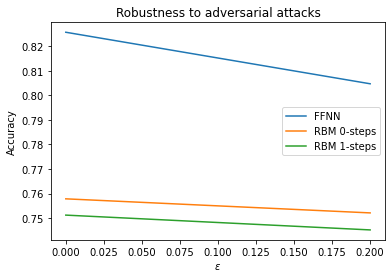

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), sharey=True)

__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_rbm_0)
# __ = ax.plot(epsilon_values, accuracies_rbm_1)
__ = ax.plot(epsilon_values, accuracies_rbm_2)
__ = ax.set_xlabel("$\epsilon$")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks")
__ = ax.legend(["FFNN", "RBM 0-steps", "RBM 1-steps","RBM 2-steps"])